In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math


In [120]:

def get_differential_filter():
    # To do
    filter_x = np.asarray([[0.0,0.0,0.0],[-1.0,0.0,1.0],[0.0,0.0,0.0]])
    filter_y =  np.asarray([[0.0,1.0,0.0],[0.0,0.0,0.0],[0.0,-1.0,0.0]])
    return filter_x, filter_y


def filter_image(im, filter):
    # To do
    y,x = im.shape
    k = filter.shape[0]
    im_rest = np.zeros((y+k-1,x+k-1))
    ki = int((k-1)/2)
    im_rest[ki:ki+y,ki: ki+x ] = im
    im_filtered = np.zeros_like(im)
    for i in range(y):
      for j in range(x):
        im_filtered[i,j] = np.sum(np.array([np.sum(i) for i in im_rest[i:i+k,j:j+k]*filter]))
    print("im_filtered shape",im_filtered.shape )
    return im_filtered


def get_gradient(im_dx, im_dy):
    # To do
    eps = 1e-8
    grad_mag = np.sqrt(im_dx*im_dx+im_dy*im_dy)
    grad_angle = np.arctan(im_dy/(im_dx+eps))
    return grad_mag, grad_angle


def build_histogram(grad_mag, grad_angle, cell_size):
    # To do
    M,N=grad_mag.shape
    M = M//cell_size
    N = N//cell_size
    ori_histo = np.zeros((M,N,6))
    for i in range(M):
      for j in range(N):
        for k1 in range(cell_size):
          for k2 in range(cell_size):
            degree = math.degrees(grad_angle[cell_size*i+k1,cell_size*j+k2])
            if degree<0 :
              degree = 180-degree
            if degree>180:
              degree= degree-180
            if degree>=165 or degree <15:
              ori_histo[i,j,0] += grad_mag[cell_size*i+k1,cell_size*j+k2]
            elif degree<45 :
              ori_histo[i,j,1] += grad_mag[cell_size*i+k1,cell_size*j+k2]
            elif degree<75 :
              ori_histo[i,j,2] += grad_mag[cell_size*i+k1,cell_size*j+k2]
            elif degree<105 :
              ori_histo[i,j,3] += grad_mag[cell_size*i+k1,cell_size*j+k2]
            elif degree<135:
              ori_histo[i,j,4] += grad_mag[cell_size*i+k1,cell_size*j+k2]
            elif degree<165:
              ori_histo[i,j,5] += grad_mag[cell_size*i+k1,cell_size*j+k2]
    return ori_histo


def get_block_descriptor(ori_histo, block_size):
    # To do
    M,N,x = ori_histo.shape
    eps = 0.001
    ori_histo_normalized = np.zeros((M-(block_size-1),N-(block_size-1), 6*block_size*block_size))
    for i in range(M-(block_size-1)):
      for j in range(N-(block_size-1)):
        for k1 in range(block_size):
          for k2 in range(block_size):
            ori_histo_normalized[i,j, 6*(block_size*k1+k2):6*(block_size*k1+k2)+6 ] = ori_histo[i,j,:]
            res = ori_histo_normalized[i,j, :]
            ori_histo_normalized[i,j,:] = res/np.sqrt(np.sum(res*res)+eps*eps)
    print(ori_histo_normalized.shape)
    return ori_histo_normalized


def extract_hog(im):
    # convert grey-scale image to double format
    im = im.astype('float') / 255.0
    # To do
    filter_x , filter_y = get_differential_filter()
    im_filtered_x = filter_image( im, filter_x)
    im_filtered_y = filter_image( im, filter_y)
    grad_mag, grad_angle = get_gradient(im_filtered_x, im_filtered_y)
    ori_histo = build_histogram(grad_mag ,grad_angle, 8)
    ori_histo_normalized = get_block_descriptor(ori_histo,2)
    # Concatenating ori_histo_normalized
    hog = np.array([[]])
    M,N,x = ori_histo_normalized.shape
    for i in range(M):
      for j in range(N):
        hog = np.concatenate((hog,[ori_histo_normalized[i,j,:]] ),axis=1)

    # visualize to verify
    visualize_hog(im, hog, 8, 2)

    return hog




In [116]:
# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='white', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()


(256, 256)
im_filtered shape (256, 256)
im_filtered shape (256, 256)
(31, 31, 24)


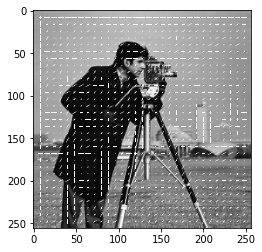

In [121]:

if __name__=='__main__':
    im = cv2.imread('/content/sample_data/cameraman.tif', 0)
    print(im.shape)
    hog = extract_hog(im)

    